In [1]:
%load_ext autoreload
%autoreload 2

import RIS_gravity_inversion.inversion as inv 
import RIS_gravity_inversion.utils as utils

import numpy as np
import pandas as pd
# make beep sound when notify is called at end of long-running cells
from IPython.display import Audio
wave = np.sin(2*np.pi*400*np.arange(10000*1)/10000)
notify = Audio(wave, rate=10000, autoplay=True)

import os 
os.getcwd()
%load_ext snakeviz

#  Setup inversion and layers

inversion region is 200 x 200 km
filtering and resampling ice from 1000m to 10000m
filtering and resampling water from 1000m to 10000m
filtering and resampling bathymetry from 1000m to 10000m
ice: 3600 points, elevations:528m to 0m
water: 3600 points, elevations:0m to -391m
bathymetry: 3600 points, elevations:-147m to -3612m
gravity: 400 points
gravity avg. elevation: 1001
bathymetry control points:10475932


<xarray.Dataset>
Dimensions:  (y: 20, x: 20)
Coordinates:
  * x        (x) float64 -1.75e+05 -1.65e+05 -1.55e+05 ... -5e+03 5e+03 1.5e+04
  * y        (y) float64 -1.515e+06 -1.505e+06 ... -1.335e+06 -1.325e+06
Data variables:
    Gobs     (y, x) float64 4.749 2.961 -0.08515 -3.487 ... -14.88 -13.07 -10.53
    z        (y, x) float64 1.001e+03 1.001e+03 ... 1.001e+03 1.001e+03

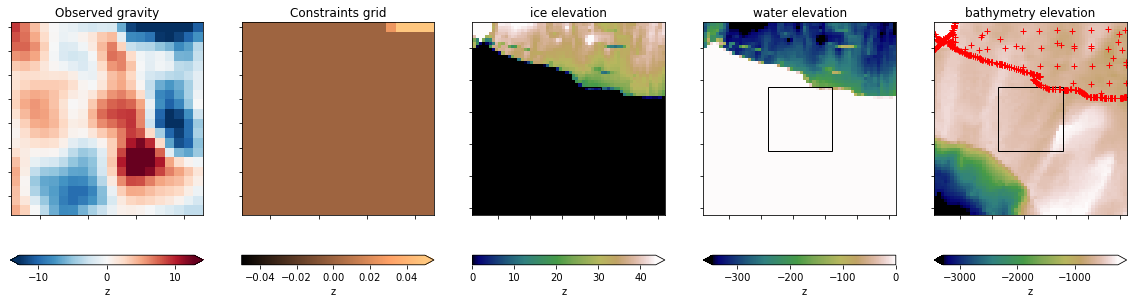

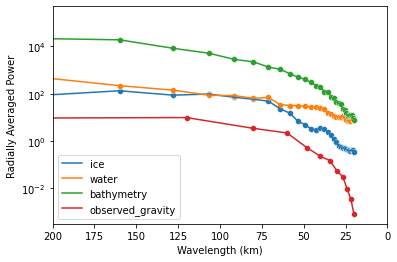

In [65]:
# starting inversion region is 1,000km x 1,000km, choose whether to zoom in, shift the 
# region to the North or West, or change the width of the buffer zone. 
inv_reg, buffer_reg = inv.setup_region(
    zoom = 400e3,#350e3,
    n_shift = 500e3,
    w_shift = 0,#100e3,
    buffer = 200e3,
    )

returned = inv.import_layers(
    layers_list = [
        'ice',
        'water',
        'bathymetry',
        # 'basement',
        # 'moho',
        ], 
    spacing_list = [
        10e3,
        10e3,
        10e3,
        # 10e3,
        # 20e3,
        ], 
    rho_list = [
        920, #890 to 917 from Muto et al. 2013
        1030, #from Muto et al. 2013
        2300,
        # 2670,
        # 3300,
        ],
    fname_list = [
        # SURFACE 
            'inversion_layers/bedmachine/BedMachine_surface_filled.nc',
        # ICEBASE
            'inversion_layers/bedmachine/BedMachine_icebase_filled.nc',
        # BED/BATHYMETRY
            # 'bathymetry_data/bedmap_bedmachine_RIGGS_grd_fill.nc',
            # 'bathymetry_data/bedmap2_bed_regional.nc',
            'inversion_layers/bedmachine/BedMachine_bed.nc',
        # BASEMENT
            # 'inversion_layers/ANTASed_mag_basement_filled.nc',
            # 'inversion_layers/RE_basement_BedMachinebed_filled.nc',
            # 'inversion_layers/lindeque_basement.nc',
        # MOHO
            # 'inversion_layers/An_moho_filt.nc',
            # 'inversion_layers/Shen_moho.nc',
            # 'inversion_layers/Pappa_moho.nc',
        ],
    grav_spacing = 10e3, 
    active_layer='bathymetry',
    buffer_region = buffer_reg,
    inversion_region = inv_reg,

    # Choose between grid and csv, similar comp. times
    # grav_file='gravity_data/rosetta_eq_source_up_continued_Gobs.nc',
    # grav_file='gravity_data/rosetta_eq_source_up_continued.csv',
    grav_file = 'gravity_data/ant4d_gravity_epsg_5k.nc',

    constraints=True,
    constraints_file='constraints_grid/constraints_grid.nc',
    constraints_points='bathymetry_data/bedmachine_RIGGS.csv',
    
    plot=True,
    plot_region=buffer_reg,
    power_spectrum=True,
    )
layers, grav, grav_spacing, constraints_grid, constraints_df, constraints_RIS_df = returned
grav

# Make prism layers

bathymetry top: -811m and bottom: -3612m
water top: -74m andbottom: -811m
ice top: 10m andbottom: -74m


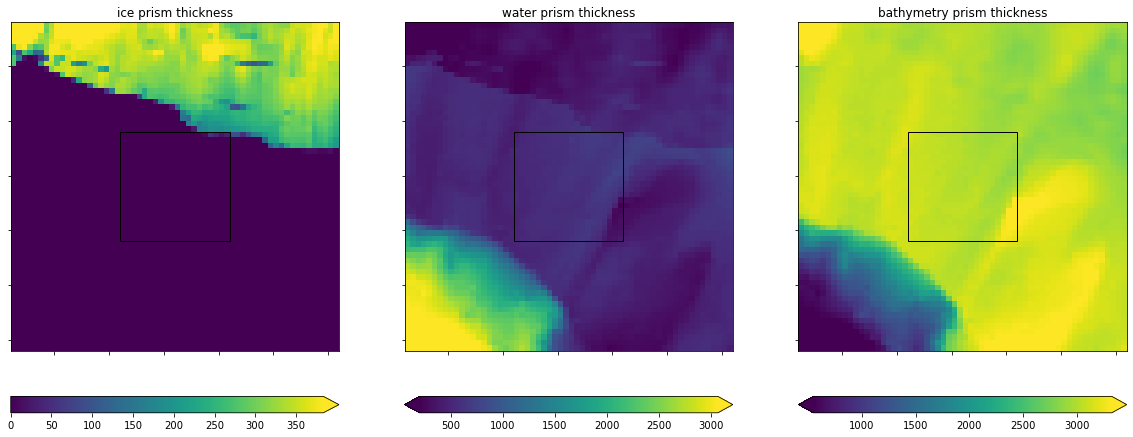

In [40]:
inv.grids_to_prism_layers( 
    layers, 
    plot=True, 
    # plot_region=inv_reg,
    plot_type='2D', 
    buffer_region = buffer_reg,
    inversion_region = inv_reg,
    ) 

# Forward gravity

converting 'gravity' from xr.Dataset to pd.DataFrame
finished ice layer
finished water layer
finished bathymetry layer


,y,x,Gobs,z,ice_forward_grav,water_forward_grav,bathymetry_forward_grav,forward_total
count,4.000000e+02,400.000000,4.000000e+02,400.0,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02
mean,-1.420000e+06,-80000.000000,2.384186e-08,1001.0,-2.220446e-18,-3.339551e-15,-2.273737e-15,-5.684342e-15
std,5.773503e+04,57735.026919,5.838040e+00,0.0,1.916774e-01,4.518298e+00,1.014669e+01,5.593500e+00
min,-1.515000e+06,-175000.000000,-1.606967e+01,1001.0,-4.219046e-02,-1.599178e+01,-3.049595e+01,-1.681465e+01
25%,-1.467500e+06,-127500.000000,-3.494121e+00,1001.0,-3.829519e-02,-2.831415e+00,-6.110082e+00,-3.363223e+00
50%,-1.420000e+06,-80000.000000,4.932184e-01,1001.0,-3.225873e-02,2.155182e-01,-3.954596e-01,-2.634460e-01
75%,-1.372500e+06,-32500.000000,3.714252e+00,1001.0,-1.729968e-02,2.771557e+00,6.287498e+00,3.444879e+00
max,-1.325000e+06,15000.000000,1.759747e+01,1001.0,2.369254e+00,1.371053e+01,3.553863e+01,1.950678e+01


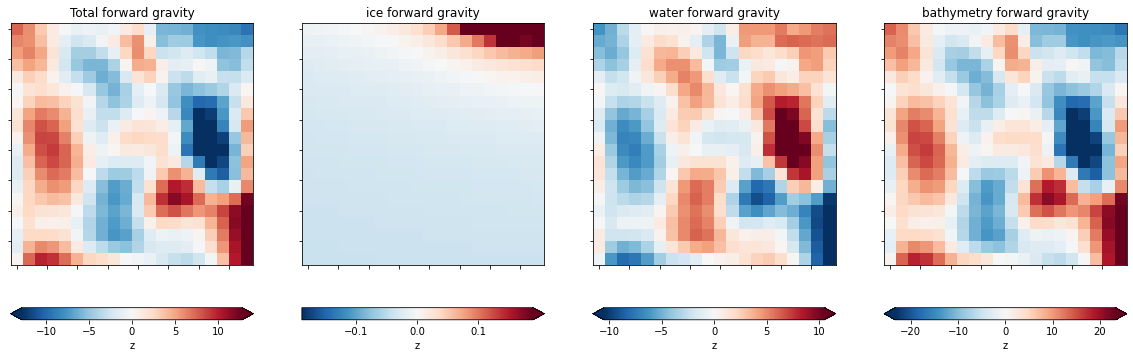

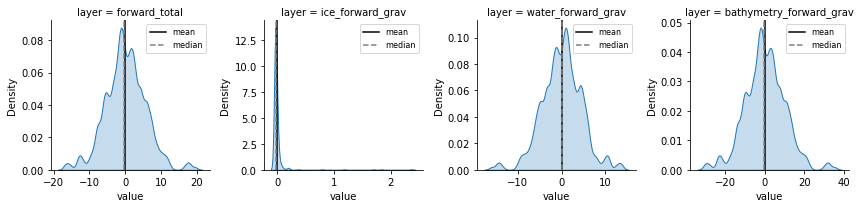

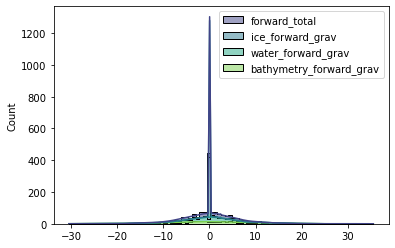

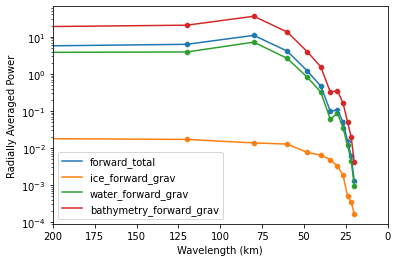

In [63]:
# use below calc at full grid extent, not just grav observation points
# grav = utils.make_grid(inv_reg, grav_spacing, 1000, "z")

df_forward = inv.forward_grav_layers(
    layers, 
    grav,  
    plot=True,
    grav_spacing=grav_spacing,
    inversion_region = inv_reg,
    # exclude_layers=['ice'],
    plot_dists=True,
    power_spectrum=True,
    )
df_forward.describe()

# Anomalies

Root mean squared residual: 4.81mGal


,y,x,Gobs,z,ice_forward_grav,water_forward_grav,bathymetry_forward_grav,forward_total,grav_corrected,misfit,reg,res
count,4.000000e+02,400.000000,4.000000e+02,400.0,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,400.000000,400.000000
mean,-1.420000e+06,-80000.000000,2.384186e-08,1001.0,-2.220446e-18,-7.105427e-16,1.321609e-14,1.250555e-14,2.384186e-08,2.384185e-08,0.328230,-0.328230
std,5.773503e+04,57735.026919,5.838040e+00,0.0,1.916774e-01,3.321997e+00,7.460959e+00,4.107183e+00,5.902022e+00,6.386582e+00,2.296189,4.809697
min,-1.515000e+06,-175000.000000,-1.606967e+01,1001.0,-4.219046e-02,-1.426085e+01,-1.607211e+01,-8.887451e+00,-1.818918e+01,-2.222659e+01,-5.792833,-18.828927
25%,-1.467500e+06,-127500.000000,-3.494121e+00,1001.0,-3.829519e-02,-1.454829e+00,-4.932615e+00,-2.722958e+00,-3.484218e+00,-3.456642e+00,-1.081068,-3.130820
50%,-1.420000e+06,-80000.000000,4.932184e-01,1001.0,-3.225873e-02,6.187043e-02,3.666758e-03,5.188709e-02,5.104321e-01,2.382985e-01,0.721372,-0.274970
75%,-1.372500e+06,-32500.000000,3.714252e+00,1001.0,-1.729968e-02,2.187830e+00,3.351953e+00,1.837636e+00,3.753127e+00,3.293602e+00,1.885923,2.677657
max,-1.325000e+06,15000.000000,1.759747e+01,1001.0,2.369254e+00,7.201349e+00,3.183489e+01,1.754009e+01,1.763427e+01,1.956285e+01,4.363854,15.477252


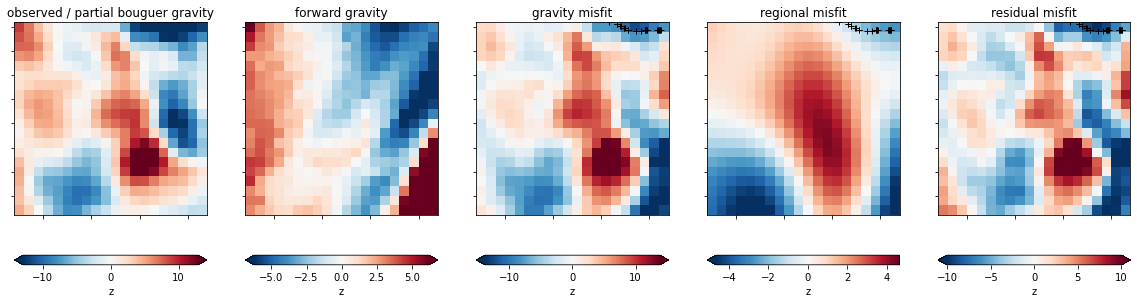

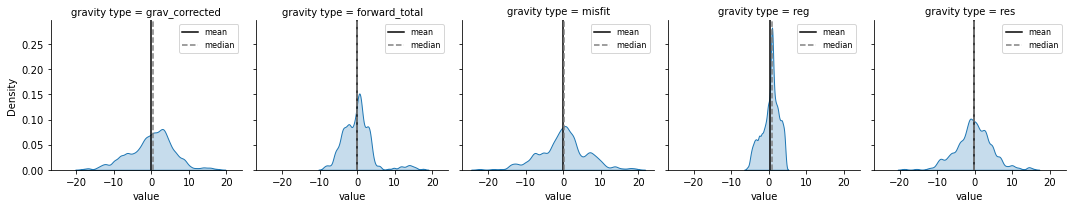

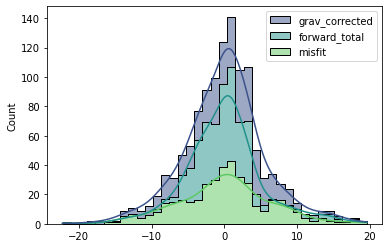

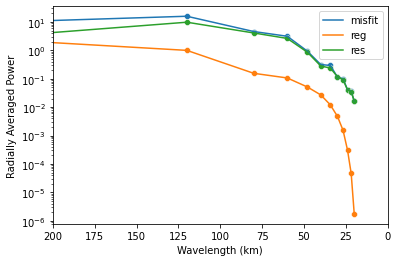

In [62]:
filter='g200e3'
df_anomalies = inv.anomalies(
        layers, 
        df_forward,
        grav_spacing, 
        'filter', 
        filter=filter,
        inversion_region=inv_reg,
        corrections=['ice'], 
        plot=True, 
        plot_constraints=True,
        constraints2plot=constraints_RIS_df,
        plot_dists=True,
        power_spectrum=True,
        )
df_anomalies.describe()

Root mean squared residual: 4.05mGal


,y,x,Gobs,z,ice_forward_grav,water_forward_grav,bathymetry_forward_grav,forward_total,grav_corrected,misfit,reg,res
count,4.000000e+02,400.000000,4.000000e+02,400.0,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02
mean,-1.420000e+06,-80000.000000,2.384186e-08,1001.0,-2.220446e-18,-7.105427e-16,1.321609e-14,1.250555e-14,2.384186e-08,2.384185e-08,2.279106e-08,1.050781e-09
std,5.773503e+04,57735.026919,5.838040e+00,0.0,1.916774e-01,3.321997e+00,7.460959e+00,4.107183e+00,5.902022e+00,6.386582e+00,4.930634e+00,4.059222e+00
min,-1.515000e+06,-175000.000000,-1.606967e+01,1001.0,-4.219046e-02,-1.426085e+01,-1.607211e+01,-8.887451e+00,-1.818918e+01,-2.222659e+01,-2.138119e+01,-1.109616e+01
25%,-1.467500e+06,-127500.000000,-3.494121e+00,1001.0,-3.829519e-02,-1.454829e+00,-4.932615e+00,-2.722958e+00,-3.484218e+00,-3.456642e+00,-2.703650e+00,-2.786156e+00
50%,-1.420000e+06,-80000.000000,4.932184e-01,1001.0,-3.225873e-02,6.187043e-02,3.666758e-03,5.188709e-02,5.104321e-01,2.382985e-01,8.887741e-01,1.839325e-01
75%,-1.372500e+06,-32500.000000,3.714252e+00,1001.0,-1.729968e-02,2.187830e+00,3.351953e+00,1.837636e+00,3.753127e+00,3.293602e+00,3.654091e+00,2.396977e+00
max,-1.325000e+06,15000.000000,1.759747e+01,1001.0,2.369254e+00,7.201349e+00,3.183489e+01,1.754009e+01,1.763427e+01,1.956285e+01,7.279570e+00,1.263821e+01


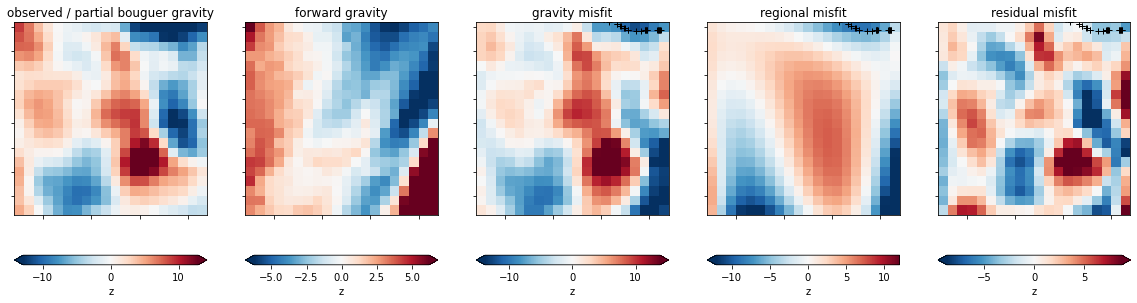

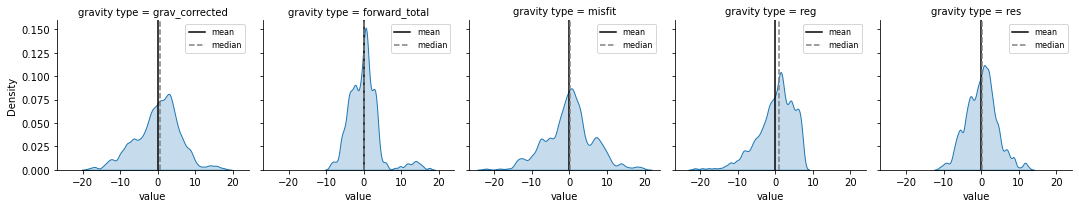

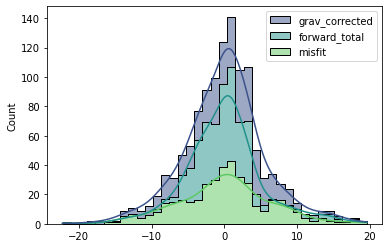

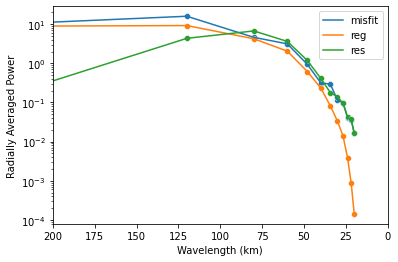

In [61]:
trend=4
df_anomalies = inv.anomalies(
        layers, 
        df_forward,
        grav_spacing, 
        'trend', 
        trend=trend,
        inversion_region=inv_reg,
        corrections=['ice'], 
        plot=True, 
        plot_constraints=True,
        constraints2plot=constraints_RIS_df,
        plot_dists=True,
        power_spectrum=True,
        )
df_anomalies.describe()

c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\pandas\core\reshape\merge.py:1207: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  warnings.warn(


Root mean squared residual: 0.65mGal


,y,x,Gobs,z,ice_forward_grav,water_forward_grav,bathymetry_forward_grav,forward_total,grav_corrected,misfit,reg,res
count,4.000000e+02,400.000000,4.000000e+02,400.0,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,400.000000,400.000000
mean,-1.420000e+06,-80000.000000,2.384186e-08,1001.0,-2.220446e-18,-7.105427e-16,1.321609e-14,1.250555e-14,2.384186e-08,2.384185e-08,-0.009707,0.009707
std,5.773503e+04,57735.026919,5.838040e+00,0.0,1.916774e-01,3.321997e+00,7.460959e+00,4.107183e+00,5.902022e+00,6.386582e+00,6.274107,0.648759
min,-1.515000e+06,-175000.000000,-1.606967e+01,1001.0,-4.219046e-02,-1.426085e+01,-1.607211e+01,-8.887451e+00,-1.818918e+01,-2.222659e+01,-18.956764,-3.269825
25%,-1.467500e+06,-127500.000000,-3.494121e+00,1001.0,-3.829519e-02,-1.454829e+00,-4.932615e+00,-2.722958e+00,-3.484218e+00,-3.456642e+00,-3.542107,-0.265891
50%,-1.420000e+06,-80000.000000,4.932184e-01,1001.0,-3.225873e-02,6.187043e-02,3.666758e-03,5.188709e-02,5.104321e-01,2.382985e-01,0.278337,-0.002281
75%,-1.372500e+06,-32500.000000,3.714252e+00,1001.0,-1.729968e-02,2.187830e+00,3.351953e+00,1.837636e+00,3.753127e+00,3.293602e+00,3.208310,0.321313
max,-1.325000e+06,15000.000000,1.759747e+01,1001.0,2.369254e+00,7.201349e+00,3.183489e+01,1.754009e+01,1.763427e+01,1.956285e+01,18.367306,3.409459


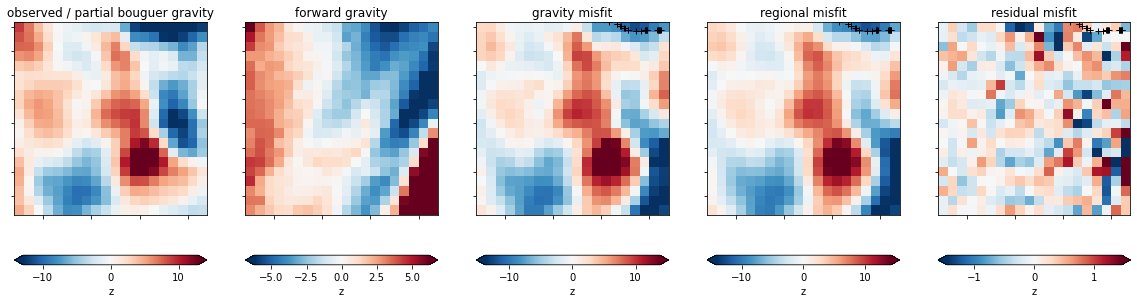

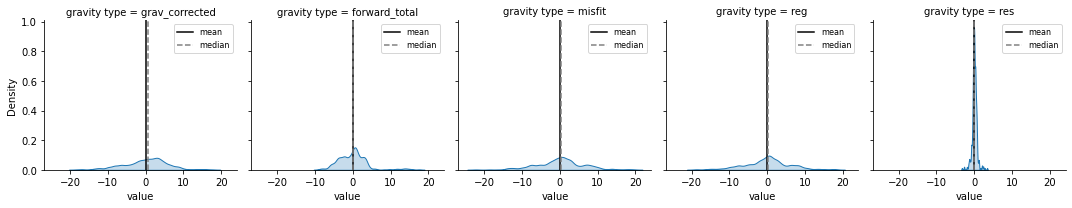

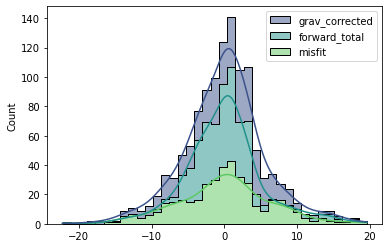

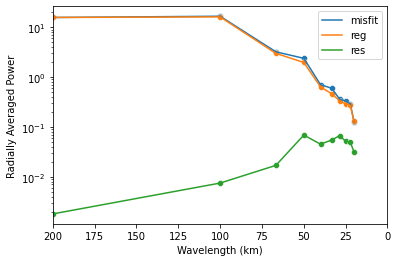

In [44]:
df_anomalies = inv.anomalies(
        layers, 
        df_forward, 
        grav_spacing, 
        'constraints', 
        constraints=constraints_df,
        constraints2plot=constraints_RIS_df,
        inversion_region=inv_reg,
        corrections=['ice'], 
        plot=True, 
        plot_constraints=True,
        plot_dists=True,
        power_spectrum=True,
        )
df_anomalies.describe()

# Geo inversion

In [49]:
# %%snakeviz --new-tab
regional_method='trend'

iter_corrections, df_inversion = inv.geo_inversion(
    active_layer='bathymetry',
    layers=layers, 
    input_grav=df_anomalies, 
    regional_method = regional_method,
    Max_Iterations=3,
    deriv_type='prisms',
    max_layer_change_per_iter=100,

    apply_constraints = False,
    constraints_grid=constraints_grid,
    exclude_layers=['ice'],

    # filter=filter, 
    trend=trend,
    # constraints=constraints_df,

    inversion_region = inv_reg,
    buffer_region=buffer_reg,
    grav_spacing = grav_spacing,
    ) 
# full size, just ROSETTA, 5km res, Ice/Water/Bathy, annulus, 5its, 5th trend,: 18m 3s
# full size, just ROSETTA, 5km res, Ice/Water/Bathy, annulus, 5its, 400km filter,: 19m 35s

# 07/27/22, full size, just ROSETTA, 20km res, Ice/Water/Bathy, annulus, 3its, constraints off
# 200km filter. 200km buffer,: 14mins
# 07/27/22, full size, just ROSETTA, 20km res, Ice/Water/Bathy, prisms, 3its, constraints off
# res from 200km filter. 200km buffer,: 2 mins

# 07/28/22, full size, just ROSETTA, 10km res, Ice/Water/Bathy, prisms, 3its, constraints off
# res from constraints. 200km buffer, mins
notify

##################################
iteration 1
initial RMS residual = 4.05mGal
RMS layer correction 15.48m
constraints not applied
calculating updated forward gravity
updating the misfits
Root mean squared residual: 2.48mGal
##################################
iteration 2
initial RMS residual = 2.48mGal
RMS layer correction 9.96m
constraints not applied
calculating updated forward gravity
updating the misfits
Root mean squared residual: 1.11mGal
##################################
iteration 3
initial RMS residual = 1.11mGal
RMS layer correction 4.46m
constraints not applied
calculating updated forward gravity
updating the misfits
Root mean squared residual: 0.5mGal
Inversion terminated after 3 iterations with least-squares norm=0 because maximum number of iterations (3) reached


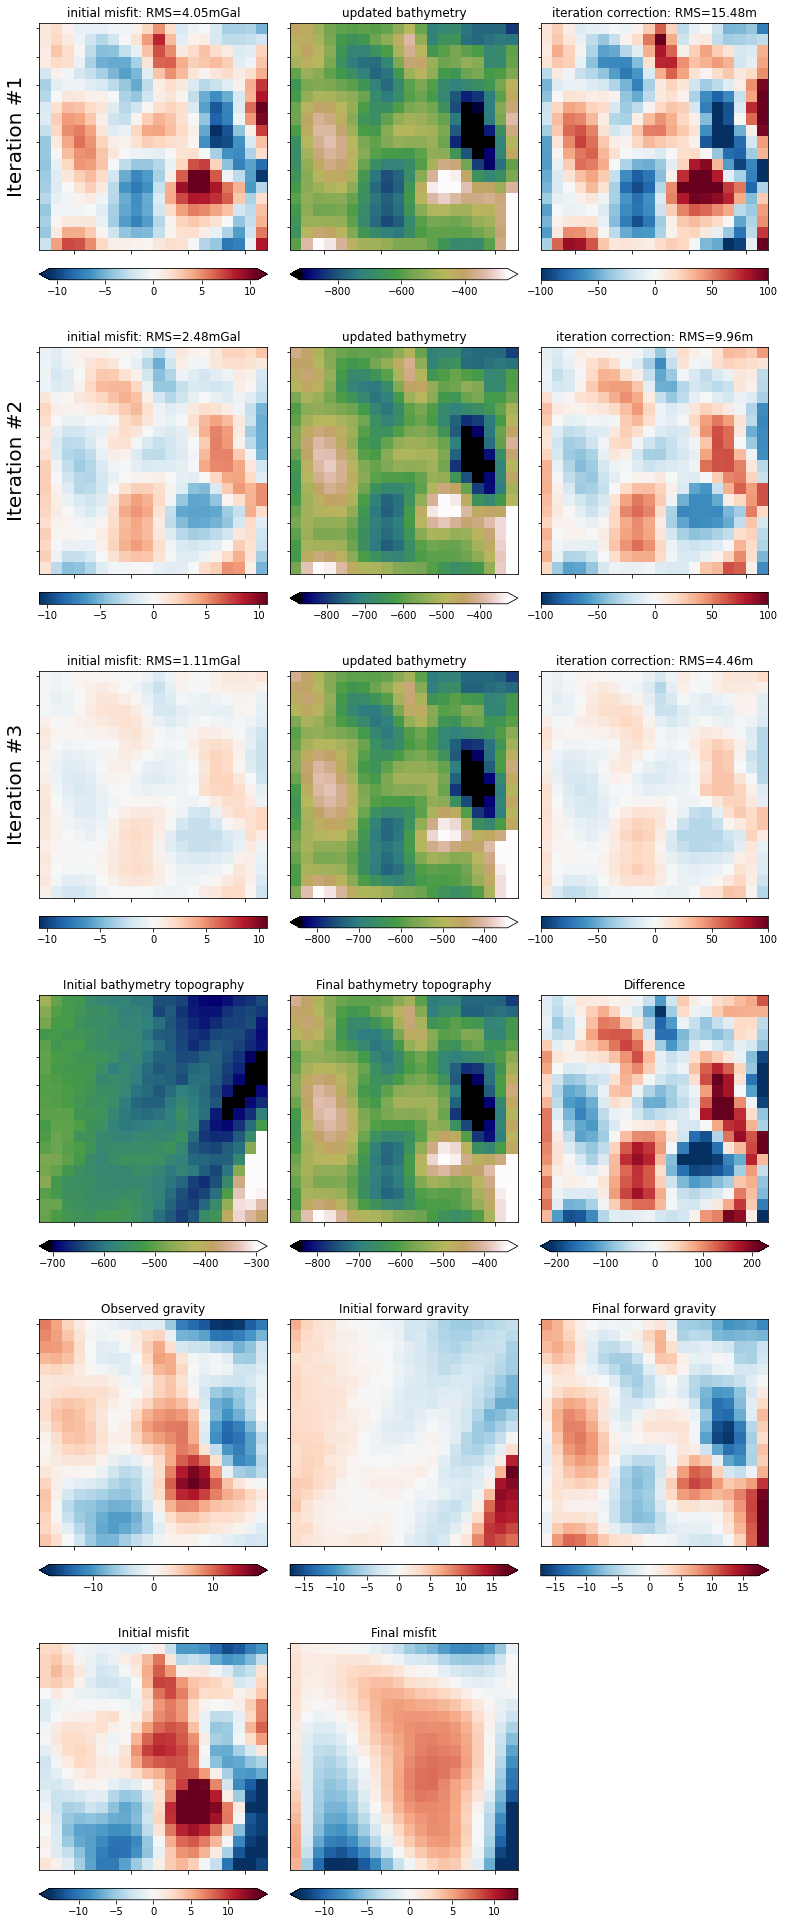

In [52]:
inv.plot_inversion_results(
    df_inversion,
    'bathymetry',
    grav_spacing,
    'epsg:3031',
    layers,
    iter_corrections,
    inversion_region = inv_reg,
    # plot_region = buffer_reg,
    plot_constraints = False,
    # constraints = constraints_RIS_df,
)

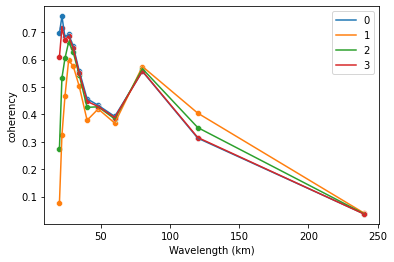

In [112]:
utils.coherency(
    grids = [
        iter_corrections[['x','y','iter_1_initial_top']],
        df_inversion[['x','y','Gobs']]],
        spacing=grav_spacing,
        region=inv_reg,
        label='0'
        )
utils.coherency(
    grids = [
        iter_corrections[['x','y','iter_1_final_top']],
        df_inversion[['x','y','Gobs']]],
        spacing=grav_spacing,
        region=inv_reg,
        label='1'
        )
utils.coherency(
    grids = [
        iter_corrections[['x','y','iter_2_final_top']],
        df_inversion[['x','y','Gobs']]],
        spacing=grav_spacing,
        region=inv_reg,
        label='2'
        )
utils.coherency(
    grids = [
        iter_corrections[['x','y','iter_3_final_top']],
        df_inversion[['x','y','Gobs']]],
        spacing=grav_spacing,
        region=inv_reg,
        label='3'
        )


# Density inversion

In [ ]:
# density_inversion(
    # density_layer='bathymetry', 
    # plot=True
    # ) 
#10mins, 200km zoom/5k, 3.5mins 400km zoom/5k (113x113 prisms, 33x33 grav)
# notify